Task 3: Customer Segmentation / Clustering 
Perform customer segmentation using clustering techniques. Use both profile information 
(from Customers.csv) and transaction information (from Transactions.csv). 
● You have the flexibility to choose any clustering algorithm and any number of clusters in 
between(2 and 10)  
● Calculate clustering metrics, including the DB Index(Evaluation will be done on this). 
● Visualise your clusters using relevant plots. 
Deliverables: 
● A report on your clustering results, including: 
○ The number of clusters formed. 
○ DB Index value. 
○ Other relevant clustering metrics. 
● A Jupyter Notebook/Python script containing your clustering code. 
Evaluation Criteria: 
● Clustering logic and metrics. 
● Visual representation of clusters. 

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge Customers and Transactions to get aggregated transaction data per customer
customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')

# Feature engineering: Aggregate transactions to get customer-level features
customer_features = customer_transactions.groupby('CustomerID').agg(
    total_value=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Merge with customer profile to add region and other details
customer_profile = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# One-hot encode categorical feature 'Region'
region_encoded = pd.get_dummies(customer_profile['Region'], drop_first=True)

# Normalize numerical features: total_value, transaction_count, avg_transaction_value
scaler = StandardScaler()
numerical_features = customer_profile[['total_value', 'transaction_count', 'avg_transaction_value']]
numerical_scaled = scaler.fit_transform(numerical_features)

# Combine numerical features and region encoded features into a final feature matrix
final_features = np.hstack([numerical_scaled, region_encoded])


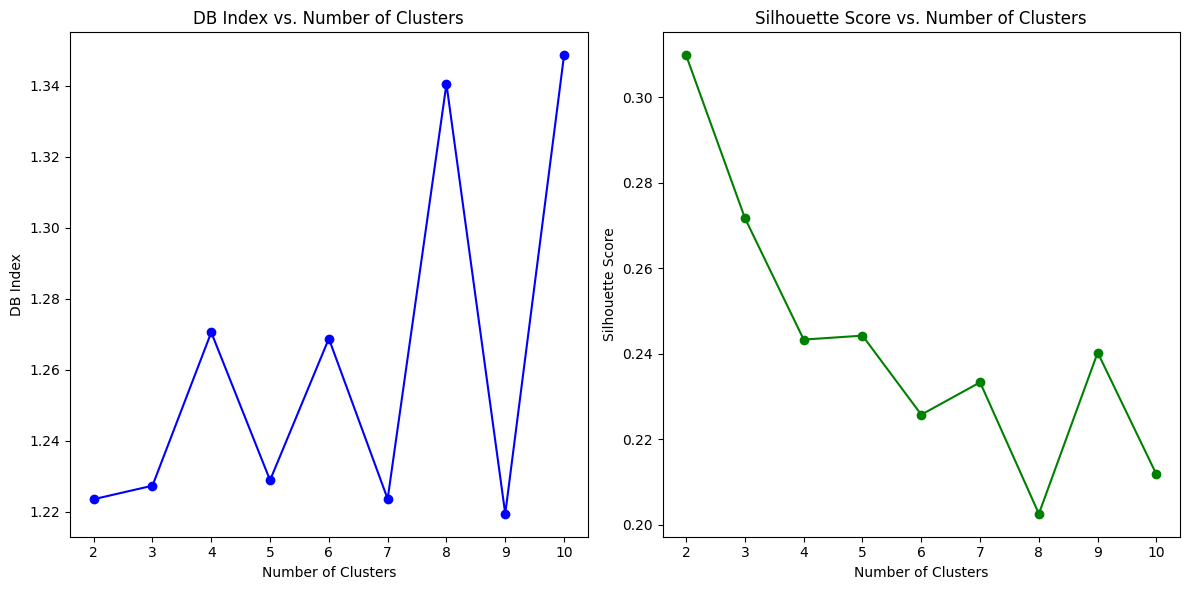

Best number of clusters based on DB Index: 9


In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Apply KMeans clustering with number of clusters between 2 and 10
inertia = []
db_index = []
silhouette = []
clusters_range = range(2, 11)

for n_clusters in clusters_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(final_features)
    
    # Store metrics
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(final_features, kmeans.labels_))
    silhouette.append(silhouette_score(final_features, kmeans.labels_))

# Plot the clustering metrics (DB Index, Silhouette Score)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(clusters_range, db_index, marker='o', color='blue', label='Davies-Bouldin Index')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(clusters_range, silhouette, marker='o', color='green', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Best number of clusters based on DB Index and Silhouette Score
best_n_clusters = clusters_range[np.argmin(db_index)]  # Choose the one with the lowest DB Index
print(f"Best number of clusters based on DB Index: {best_n_clusters}")


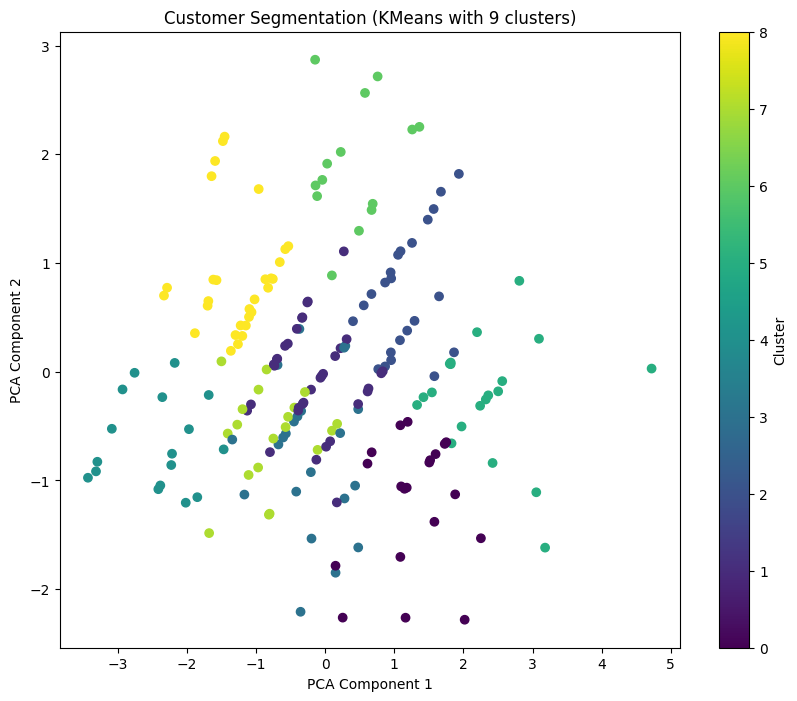

DB Index for the best clustering solution: 1.2194787754847871
Silhouette Score for the best clustering solution: 0.24026850185475326


In [42]:
# Apply KMeans with the best number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(final_features)

# Visualize the clusters using PCA (2D reduction)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_features)
customer_profile['PCA1'], customer_profile['PCA2'] = pca_components[:, 0], pca_components[:, 1]

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
plt.scatter(customer_profile['PCA1'], customer_profile['PCA2'], c=customer_profile['Cluster'], cmap='viridis')
plt.title(f'Customer Segmentation (KMeans with {best_n_clusters} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Calculate DB Index and Silhouette Score for the best clustering solution
db_index_best = davies_bouldin_score(final_features, customer_profile['Cluster'])
silhouette_best = silhouette_score(final_features, customer_profile['Cluster'])

print(f"DB Index for the best clustering solution: {db_index_best}")
print(f"Silhouette Score for the best clustering solution: {silhouette_best}")
